In [52]:
import re
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from itertools import chain
from collections import Counter

from reviews.config import root_dir

data_dir = root_dir / "data (copy)"
out_dir = root_dir / "output (copy)"
processed_data_dir = data_dir / "processed"
asum_output_dir = root_dir / "output" / "asum"

sns.set_style("white")

primary_color = "#ECE81A"  # 108de4ff"
secondary_color = "#C3C5C5"

# Models Comparison

In [53]:
total_df = pd.DataFrame()
for n_topics in [10, 20, 30, 50]:
    for model in ["asum", "jst"]:
        for norm in ["raw", "stemming", "lemmatization"]:
            filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}.csv"

            if not filename.exists():
                continue

            df = pd.read_csv(filename)
            df["model"] = model
            df["normalization"] = norm

            total_df = pd.concat((df, total_df))

In [54]:
total_df[total_df["model"] == "asum"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
lemmatization 10        0.610995     0.822938  0.783224
              20        0.609943     0.825730  0.787974
              30        0.609353     0.826766  0.789831
              50        0.615289     0.832343  0.797935
raw           10        0.603015     0.819242  0.778656
              20        0.604509     0.824062  0.786347
              30        0.604621     0.825871  0.789284
              50        0.614762     0.835591  0.803572
stemming      10        0.626172     0.836788  0.803171
              20        0.619642     0.831365  0.795388
              30        0.619473     0.834202  0.800157
              50        0.626493     0.841002  0.810205

In [55]:
total_df[total_df["model"] == "jst"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
stemming      10        0.563276     0.764685  0.702036
              20        0.557473     0.757249  0.692407
              30        0.558806     0.757243  0.692017
              50        0.559091     0.761021  0.697063

(0.55, 0.65)

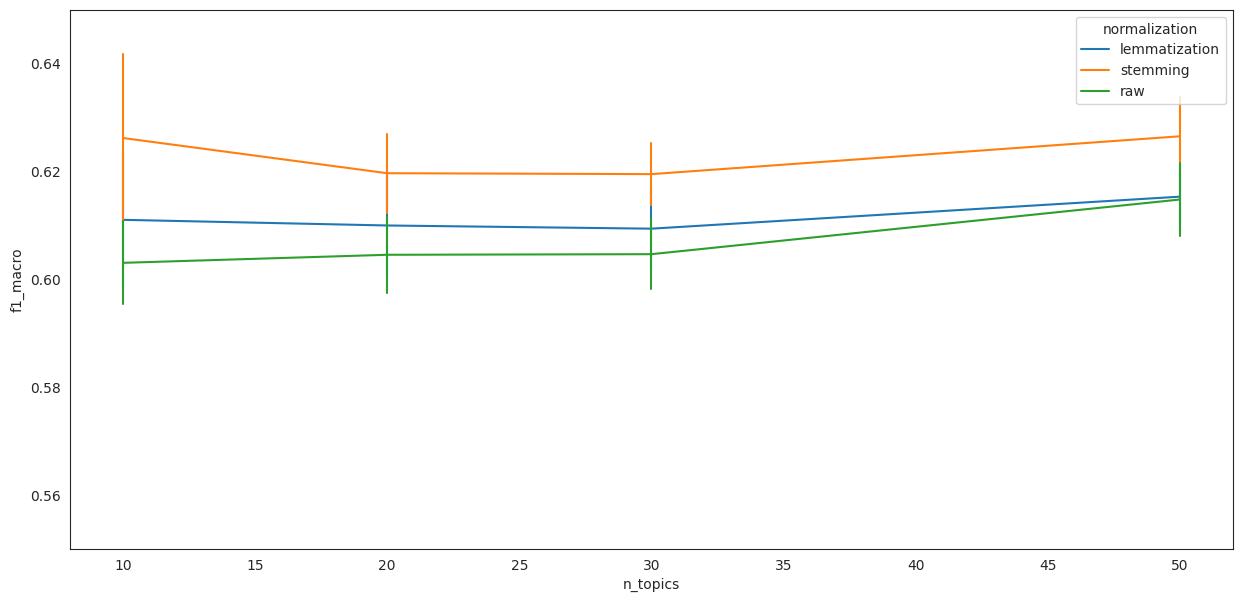

In [56]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["model"] == "asum"],
    y="f1_macro",
    x="n_topics",
    hue="normalization",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.55, 0.65])

(0.5, 0.65)

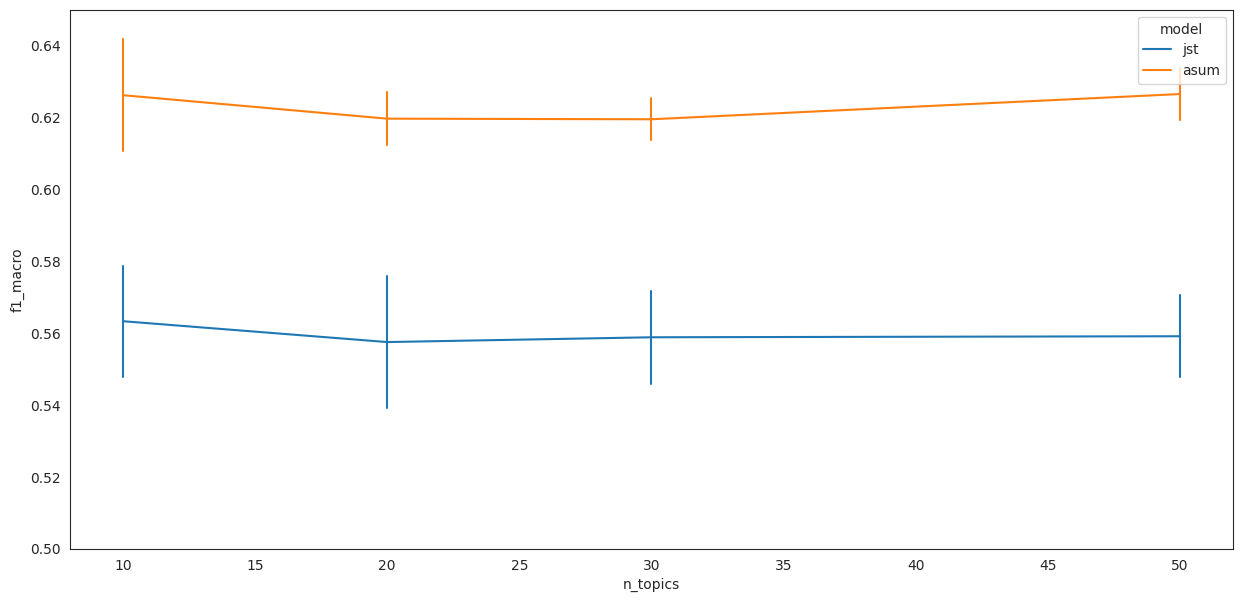

In [57]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["normalization"] == "stemming"],
    y="f1_macro",
    x="n_topics",
    hue="model",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.5, 0.65])

## Split by Commas and Conjunctions

In [58]:
total_df = pd.DataFrame()
n_topics = 50
model = "asum"
norm = "stemming"
for extra in ["", "_conj", "_comma"]:
    filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}{extra}.csv"

    if not filename.exists():
        continue

    df = pd.read_csv(filename)
    df["extra"] = "stemming" if extra == "" else extra.replace("_", "")

    total_df = pd.concat((df, total_df))
total_df

,Unnamed: 0,run,n_topics,f1_macro,f1_weighted,f1_micro,extra
0,0,0,50,0.628430,0.844109,0.815090,stemming
1,1,1,50,0.621672,0.840200,0.809873,stemming
2,2,2,50,0.618471,0.834550,0.800934,stemming
3,3,3,50,0.616923,0.838309,0.807684,stemming
4,4,4,50,0.638262,0.849304,0.821840,stemming
5,5,5,50,0.623417,0.836290,0.802831,stemming
6,6,6,50,0.630242,0.842991,0.812755,stemming
7,7,7,50,0.636666,0.848965,0.821621,stemming
8,8,8,50,0.628552,0.840253,0.808450,stemming
9,9,9,50,0.622294,0.835045,0.800971,stemming


/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1174: RuntimeWarning:

All-NaN axis encountered

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1175: RuntimeWarning:

All-NaN axis encountered



(0.6, 0.65)

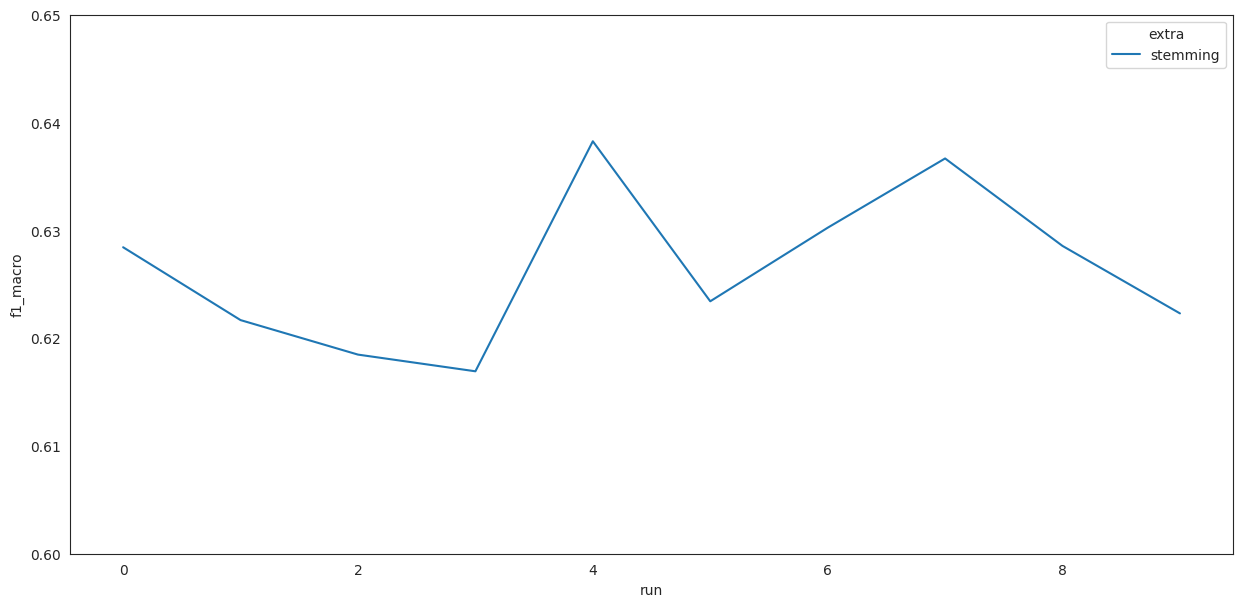

In [59]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df, y="f1_macro", x="run", hue="extra", ax=ax, err_style="bars", errorbar="sd"
)
ax.set_ylim([0.6, 0.65])

# ASPECT BASED SENTIMENT ANALYSIS (ASUM)

In [60]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary
EXTRA = ""  # _conj

In [61]:
n_runs = 10
n_topics = 50
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

# Read Reviews Data

In [62]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}{EXTRA}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.50%
Empty Reviews: 0.05%


In [63]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

## PI = documents x sentiment

In [64]:
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

## PHI = vocabulary x senti aspects

In [65]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)

## THETA = documents x senti aspects


In [66]:
def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

In [67]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  111


In [68]:
(f_theta_df > T).sum(axis=1).describe()

count    28872.000000
mean         1.664381
std          0.932739
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [69]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0        [S0-T10, S0-T34]
1        [S0-T37, S1-T12]
2         [S0-T47, S1-T7]
3                [S1-T25]
4                [S0-T36]
               ...       
28978     [S0-T7, S0-T42]
28979    [S1-T10, S1-T33]
28980            [S0-T40]
28981            [S0-T36]
28982            [S0-T10]
Length: 28983, dtype: object

In [70]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
# reviews_df.to_json(asum_output_dir / "topics.json", orient="records")
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 37, 'colname': 'S0-...
2        [{'sentiment': 0, 'topic': 47, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 25, 'colname': 'S1-...
4        [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 10, 'colname': 'S1-...
28980    [{'sentiment': 0, 'topic': 40, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
28982    [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

## ProbWords

In [71]:
prob_words_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")
columns = prob_words_df.columns.map(map_topic_sentiment)

In [72]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    if match is None:
        print(text)
    word, weight = match.groups()
    return word, float(weight)


def plot_prob_words():
    n_top_words = 20
    total_df = pd.DataFrame()

    fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(50, 50))
    for idx, item in enumerate(columns):
        if item is None:
            continue

        ax = axes[
            int(int(item["topic"] / 10) * 2 + item["sentiment"]),
            int(item["topic"] % 10),
        ]
        words = prob_words_df[item["colname"]][:n_top_words]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        w = weights.copy()
        w["colname"] = item["colname"]
        total_df = pd.concat((total_df, w))

        ax.barh(weights["names"], weights["weights"], height=0.5)
        ax.set_title(item["colname"])

        ax.set_xlabel(f"Topic {item['topic'] + 1}")
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

    fig.tight_layout()

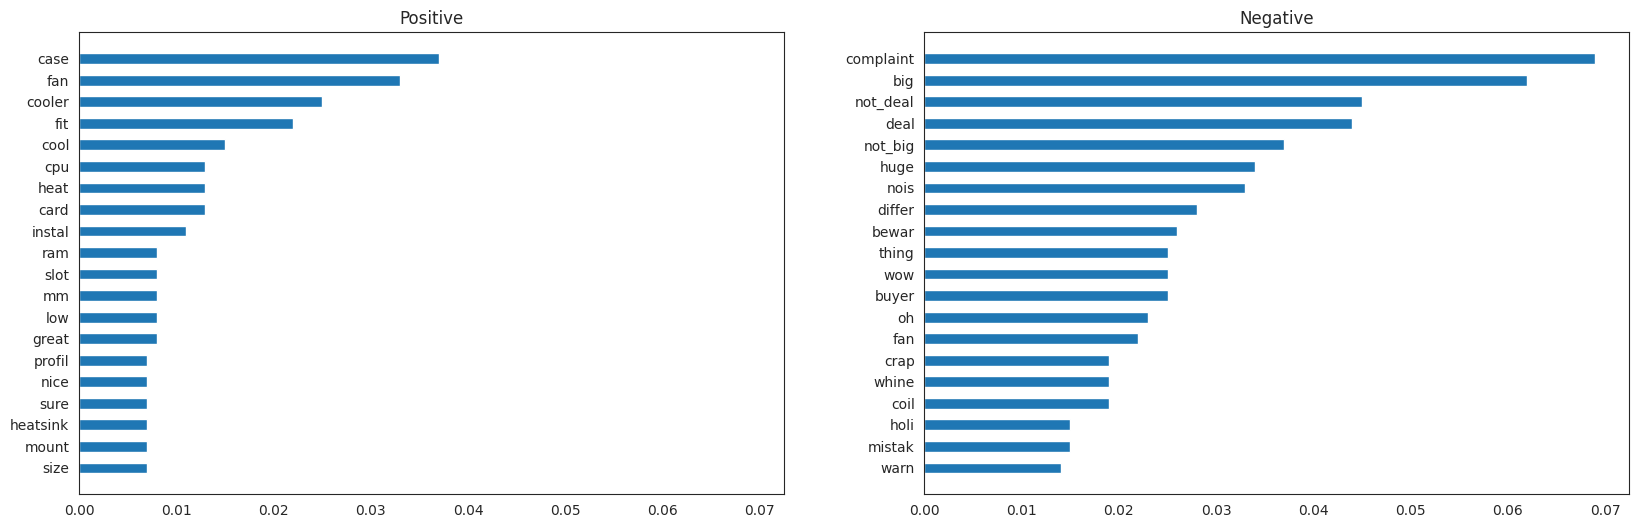

In [73]:
def show_topic(topic, n=20):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    axes = axes.flatten()

    for s in range(2):
        words = prob_words_df[f"S{s}-{topic}"][:n]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        axes[s].barh(weights["names"], weights["weights"], height=0.5)
        axes[s].set_title("Positive" if s == 0 else "Negative")


def print_examples(topic, k=5):
    ddf = reviews_df.copy()
    ddf["topics"] = ddf["topics"].apply(lambda x: set([y["colname"] for y in x]))

    pos_examples = pd.Series(
        [row["text"] for i, row in ddf.iterrows() if f"S0-{topic}" in row["topics"]]
    ).sample(k)
    neg_examples = pd.Series(
        [row["text"] for i, row in ddf.iterrows() if f"S1-{topic}" in row["topics"]]
    ).sample(k)

    print(
        "Positive ---------------------------------------------------------------------------------\n"
    )
    [print(">----------\n", ex) for ex in pos_examples]

    print(
        "\nNegative ---------------------------------------------------------------------------------"
    )
    [print(">----------\n", ex) for ex in neg_examples]


topic_mapping = {
    "T0": "recommended",
    "T1": "performance",  # gaming
    "T2": "installation",  # performance
    "T3": "drivers",
    "T4": "graphic card",
    "T5": "motherboard",
    "T6": "build",
    "T7": "temperature",
    "T8": "price",
    "T9": "quality",
    "T10": "storage",
    "T11": "motherboard",
    "T12": "graphic card",
    "T13": "brand",
    "T14": "memory",
    "T15": "cooling system",
    "T16": "motherboard",
    "T17": "installation",
    "T18": "performance",
    "T19": "monitor",
    "T20": "cooling system",
    "T21": "quality",
    "T22": "motherboard",
    "T23": "power supply system",
    "T24": "service",
    "T25": "installation",
    "T26": "case",
    "T27": "build",
    "T28": "cooling system",
    "T29": "power supply system",
    "T30": "aesthetic",
    "T31": "cooling system",
    "T32": "sound card",
    "T33": "motherboard",
    "T34": "thermal paste",
    "T35": "recommended",
    "T36": "pc replacement / upgrade",
    "T37": "price",
    "T38": "audio/video cards",  # ..........
    "T39": "service",
    "T40": "price",
    "T41": "service",
    "T42": "memory",
    "T43": "gaming",
    "T44": "cooling system",
    "T45": "processor",
    "T46": "memory",
    "T47": "processor",
    "T48": "recommended",
    "T49": "network",
}

topic = "T2"
show_topic(topic, n=20)

In [74]:
print_examples(topic)

Positive ---------------------------------------------------------------------------------

>----------
 I'm using it as a second fan on my NH-U9S. It moves a bunch of air for the size and it is virtually silent.
>----------
 I'm sure it cools well and is quiet, but the photo is incorrect. The cooler is entirely silver in color, there is no blackout top shroud unless you step up to the darkbase, which was really too bad.  If you are looking for a silver CPU cooler I suggest looking into the hyper evo 212 and save some loot.
>----------
 great
>----------
 This was my 2nd attempt at purchasing a Good Video Card for my son's "Excalibur" Desktop that I had just finished building for him for his games, video & Picturing editing, and of course his academic pursuits. The 1st Video Card I brought for my son's Excalibur Rig (A GIGABYTE Radeon HD 6450 1GB DDR3 DVI-I / D-Sub / HDMI Low Profile Graphics Card, GV-R645OC-1GI ) while did well with the 2nd and 3rd requirements the card fell short in 

## Sentiment

In [75]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

fig = px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
    width=400,
    height=400,
)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment.png")
fig

### Sentiment Over Time

In [76]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
    width=2000,
    height=500,
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment_over_time.png")
fig

## Topics

In [77]:
count = Counter()
for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = (
    topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
)
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=[secondary_color],
    category_orders=dict(topic=order),
    width=1000,
    height=600,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig1.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig1.write_image("../output/topics.png")
fig1

fig1

In [78]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    width=1000,
    height=600,
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig2.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig2.write_image("../output/topics_sentiment.png")
fig2

In [79]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# global sentiment
sentiment_df = competitors_df.groupby("brand")["sentiment"].value_counts()
sentiment_df_perc = sentiment_df / sentiment_df.groupby("brand").sum()
sentiment_df_perc = (
    pd.DataFrame(sentiment_df_perc * 100)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)

fig2 = px.bar(
    sentiment_df_perc,
    x="count",
    y="brand",
    color="sentiment",
    barmode="relative",
    category_orders=dict(brand=["corsair", *competitors]),
)
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_xaxes(showgrid=False, title_text="", showticklabels=False)
fig2.update_layout(margin=dict(l=0, t=0, r=0, b=0))
fig2

In [80]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# positive sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "positive"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig3 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig3.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig3.update_yaxes(showgrid=False, title_text="# Reviews")
fig3.update_layout({"margin": dict(l=0, r=0, b=0)})
fig3

In [81]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# negative sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "negative"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig4 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig4.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig4.update_yaxes(showgrid=False, title_text="# Reviews")
fig4.update_layout({"margin": dict(l=0, r=0, b=0)})
fig4

In [82]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 37, 'colname': 'S0-...
2        [{'sentiment': 0, 'topic': 47, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 25, 'colname': 'S1-...
4        [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 10, 'colname': 'S1-...
28980    [{'sentiment': 0, 'topic': 40, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
28982    [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [83]:
def map_topics(x):
    [y.update({"name": topic_mapping[f"T{y['topic']}"]}) for y in x]
    return x


map_topics(reviews_df["topics"][0])

[{'sentiment': 0, 'topic': 10, 'colname': 'S0-T10', 'name': 'storage'},
 {'sentiment': 0, 'topic': 34, 'colname': 'S0-T34', 'name': 'thermal paste'}]

In [84]:
reviews_df["topics"] = reviews_df["topics"].apply(map_topics)

In [85]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 37, 'colname': 'S0-...
2        [{'sentiment': 0, 'topic': 47, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 25, 'colname': 'S1-...
4        [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 10, 'colname': 'S1-...
28980    [{'sentiment': 0, 'topic': 40, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 36, 'colname': 'S0-...
28982    [{'sentiment': 0, 'topic': 10, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [86]:
reviews_df.to_json(asum_output_dir / "reviews_sentiments.json.gz", orient="records")

# ASPECT BASED SENTIMENT ANALYSIS (JST)

In [87]:
NORM = "stemming"
FIELD = "text"

n_runs = 10
n_topics = 50
iterations = 1000

alpha = -1
beta = -1
gamma = -1

# Read Reviews Data

In [88]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.50%
Empty Reviews: 0.05%


In [89]:
# columns name
columns_name = []

for x in range(2):
    for y in range(n_topics):
        columns_name.append("S" + str(x) + "-T" + str(y))

## PHI = vocabulary x senti aspects

In [90]:
# prepare phi file for analysis
with open(out_dir / "jst" / "final.phi") as f:
    lines = f.readlines()

    phi = {}
    tmp = ""
    for i, line in enumerate(lines):
        if i % 2 != 0:
            phi[tmp] = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
        else:
            tmp = line.strip()

phi_df = pd.DataFrame(phi)
phi_df.columns = columns_name
phi_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.013536,0.000002,0.000002,0.009105,0.007058,0.018535,0.000002,0.076919,0.015572,0.006026,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000001,0.000002,0.000002,0.000801,0.000001,0.000002,0.009759,0.139185,0.017451,0.000001,...,0.011107,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.005046,0.004171
2,0.000001,0.000002,0.000002,0.011106,0.000589,0.000002,0.019516,0.028327,0.000003,0.004645,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000001,0.000002,0.040987,0.000001,0.000001,0.042543,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.018339,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
4,0.000001,0.000002,0.000002,0.008005,0.005882,0.000002,0.000190,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.003650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20358,0.000001,0.000002,0.000002,0.000001,0.000001,0.000213,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20359,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20360,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001


## PI = documents x sentiment

In [91]:
# prepare pi file for analysis
pi_df = pd.read_csv(out_dir / "jst" / "final.pi", sep=" ", header=None)
pi_df.drop([0, 1, 4], axis=1, inplace=True)
pi_df.columns = ["S0", "S1"]
pi_df

,S0,S1
0,0.745614,0.254386
1,0.028090,0.971910
2,0.061905,0.938095
3,0.119048,0.880952
4,0.722222,0.277778
...,...,...
28978,0.932432,0.067568
28979,0.417808,0.582192
28980,0.722222,0.277778
28981,0.722222,0.277778


## THETA = documents x senti aspects

In [92]:
with open(out_dir / "jst" / "final.theta") as f:
    lines = f.readlines()

    theta = []
    tmp = []
    for i, line in enumerate(lines):
        if i % 3 != 0:
            values = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
            tmp.extend(values)
        else:
            if tmp:
                theta.append(tmp)
                tmp = []

theta_df = pd.DataFrame(theta, columns=columns_name)
theta_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.377647,0.001176,0.001176,...,0.003448,0.003448,0.003448,0.003448,0.279310,0.003448,0.003448,0.003448,0.003448,0.003448
1,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.000508,0.000508,0.000508,0.000508,0.000508,0.447208,0.000508,0.244162,0.000508,0.000508
3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
4,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.080198,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
28978,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
28979,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.526230,0.001639,0.001639,...,0.001176,0.001176,0.001176,0.095294,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176
28980,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000


In [93]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  31


In [94]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0        [S0-T7, S0-T42, S1-T5, S1-T44]
1                      [S1-T28, S1-T39]
2              [S0-T19, S1-T45, S1-T47]
3                       [S1-T7, S1-T29]
4                              [S0-T39]
                      ...              
28977          [S0-T30, S0-T41, S1-T11]
28978                  [S0-T24, S0-T38]
28979    [S0-T7, S0-T18, S1-T8, S1-T12]
28980                          [S0-T42]
28981                           [S0-T6]
Length: 28982, dtype: object

In [95]:
(f_theta_df > T).sum(axis=1).describe()

count    28951.000000
mean         3.031018
std          1.424995
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
dtype: float64

In [96]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
1        [{'sentiment': 1, 'topic': 28, 'colname': 'S1-...
2        [{'sentiment': 0, 'topic': 19, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 7, 'colname': 'S1-T...
4        [{'sentiment': 0, 'topic': 39, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 24, 'colname': 'S0-...
28979    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28980    [{'sentiment': 0, 'topic': 42, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 6, 'colname': 'S0-T...
28982                                                  NaN
Name: topics, Length: 28983, dtype: object

In [97]:
for x in reviews_df["topics"]:
    if type(x) is float:
        print(x)

nan


## Sentiment

In [98]:
doc_sentiment = pi_df.idxmax(axis=1).map(
    lambda x: "positive" if x == "S0" else "negative"
)
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

# Sentiment Over Time

In [99]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics

In [100]:
count = Counter()
for x in reviews_df["topics"].values:
    if type(x) is float:
        print(x)
        continue
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
# topics_count["topic"] = topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=["#108de4"],
    category_orders=dict(topic=order),
    height=1000,
    width=1200,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})
fig1

nan


In [101]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    if type(t) is float:
        print(t)
        continue

    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

# pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

# neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

nan
